In [62]:
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.train.losses import MaximumLikelihoodLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from jax import vmap
import pandas as pd
import scipy
import jax
from flowjax.bijections import Affine, Invert
import flowjax.bijections as bij
import jax
import matplotlib.pyplot as plt
from flowjax.distributions import LogNormal, Transformed
from jaxtyping import ArrayLike
from scipy.stats.distributions import lognorm

In [71]:
#observed data
filename = "../simulation/observed_data/observed_stats.csv"
x_o = pd.read_csv(filename)
#simulated data round 1
filename2 = "../simulation/output/round_1/summary_stats_r1.csv"
x = pd.read_csv(filename2)
#params for simulations round 1
filename3 = "../simulation/output/round_1/thetas_r1.csv"
theta = pd.read_csv(filename3)

In [64]:
#simulated data round 1
filename4 = "../simulation/output/round_1/summary_stats_r1.csv"
x_prev = pd.read_csv(filename4)
#params for simulations round 2
filename5 = "../simulation/output/round_1/thetas_r1.csv"
theta_prev = pd.read_csv(filename5)

In [65]:
to_drop = [#correlation >0.99
    "y1_domestic",
    "y1_scot",
    "y1_captive",
    "y1_eu",
    "y1_lyb",
    "y3_domestic_captive_lyb",
    "divergence_domestic_eu",
    "y3_domestic_scot_lyb",
    "y3_domestic_eu_lyb",
    "divergence_captive_lyb",
    "segregating_sites_lyb",
    "segregating_sites_eu",
    "divergence_scot_lyb",
    "f4_domestic_scot_captive_lyb",
    "f4_domestic_captive_eu_lyb",
    "f4_domestic_scot_eu_lyb",
    "diversity_domestic",
    "y3_domestic_scot_captive",
    "y3_scot_captive_eu",
    "f2_domestic_eu",
    "y2_domestic_lyb",
    "y3_scot_captive_lyb",
    "divergence_captive_eu",
    "pc1_dist_domestic_eu",
    # outlier noise model method r1 (>1)
    'tajimas_d_eu',
    'relatedness_domestic_lyb',
    'pc1_iqr_domestic',
    'pc1_iqr_eu',
    'pc1_iqr_lyb',
    'pc2_iqr_domestic',
    'pc2_iqr_lyb',
    # outlier noise model method r2 (>0.8)
    'relatedness_captive_lyb',
    'pc1_median_eu',
    'pc2_dist_domestic_lyb',
    # drop_one algorithm, achieved 0.7788 hdr
    'pc2_iqr_eu',
    'relatedness_domestic_eu',
    'tajimas_d_lyb',
    'pc1_dist_captive_eu',
    'fst_scot_lyb',
    'pc2_iqr_scot',
    'pc1_dist_scot_lyb',
    'pc1_dist_eu_lyb']

In [66]:
#(previous round for scaling)
combined_x_prev = pd.concat([x_prev, x_o], ignore_index=True)
combined_x_prev = combined_x_prev.drop(columns=to_drop)
combined_x_prev = combined_x_prev.to_numpy(dtype=np.float32)
np.shape(combined_x_prev)

(10001, 93)

In [67]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 93)

In [68]:
# (for first round)
theta_prev = theta
# create affine transformation for first round data
theta_prev = theta_prev.to_numpy(dtype=np.float32)
theta_prev_log = jnp.log(theta_prev)

preprocess_theta = Affine(-theta_prev_log.mean(axis=0)/theta_prev_log.std(axis=0), 1/theta_prev_log.std(axis=0))

In [69]:
## normalise theta (target)
theta = theta.to_numpy(dtype=np.float32)
theta_log = jnp.log(theta)

theta_t = jax.vmap(preprocess_theta.transform)(theta_log)
np.shape(theta_t)

(10000, 16)

In [34]:
#(for first round)
combined_x_prev = combined_x
# create affine transformation for stats from first round data
preprocess_x = Affine(-combined_x_prev.mean(axis=0)/combined_x_prev.std(axis=0), 1/combined_x_prev.std(axis=0))

In [35]:
## normalise simulated data
print("combined_x shape", np.shape(combined_x))
combined_x_t = jax.vmap(preprocess_x.transform)(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 93)
x_t shape (10000, 93)
x_o_t shape (1, 93)


In [45]:
#serialise scaler models between rounds
model_theta = preprocess_theta
eqx.tree_serialise_leaves("./sequential_files/theta_scaler.eqx", model_theta)

model_x = preprocess_x
eqx.tree_serialise_leaves("./sequential_files/x_scaler.eqx", model_x)

In [127]:
# deserialise scalers to use in sequential

preprocess_theta = Affine()
preprocess_theta = eqx.tree_deserialise_leaves("./sequential_files/theta_scaler.eqx", preprocess_theta)

RuntimeError: Deserialised leaf at path (GetAttrKey(name='loc'),) has changed dtype from float32 in `like` to int32 on disk.

In [44]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior

s = jnp.array((0.7, 0.7, 0.5, 0.3, 1, 1, 0.7, 0.6, 1, 1, 1.5, 1, 1.3, 1, 1, 0.5))

kwargs = {
    "loc": jnp.array((0, 10000, 500, 0, 0, 0, 0, 0, 0, 0, 5000, 0, 0, 0, 0, 0.4e-8)),
    "scale": jnp.array((np.exp(3), 60000, 3000, 3000, 0.07, 0.07, np.exp(3), 100, 60000, 20000, 100000, 4000, 20000, 60000, 1e-8, 9e-9))
}

log_norm_flowjax = scipy_like_log_normal(s, **kwargs)
log_norm_flowjax = log_norm_flowjax.merge_transforms()


In [46]:
reparam_prior, reparam_transform = log_norm_flowjax.base_dist, log_norm_flowjax.bijection
print("Reparam prior is:", type(reparam_prior).__name__)  # Normal(0, 1)
print("Reparam transform is:", type(reparam_transform).__name__) 
print("Where chain contains:", [type(b).__name__ for b in reparam_transform.bijections])

Reparam prior is: StandardNormal
Reparam transform is: Chain
Where chain contains: ['Affine', 'Exp', 'Affine']


In [49]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=reparam_prior,
    transformer=bij.Affine(),
    cond_dim=x_o_t.size,
)

In [48]:
#for sequential:
flow = eqx.tree_deserialise_leaves("./sequential_files/posterior_r1", flow)

TreePathError: Error at leaf with path (GetAttrKey(name='bijection'), GetAttrKey(name='bijection'), GetAttrKey(name='bijection'), GetAttrKey(name='cond_shape'), SequenceKey(idx=0))

In [50]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    )

In [51]:
#for first round
loss_fn = MaximumLikelihoodLoss()

In [40]:
#for subsequent rounds
loss_fn = ContrastiveLoss(reparam_prior, n_contrastive=10)

In [52]:
fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=theta_t,
    condition=x_t,
    max_epochs=1000,
    optimizer=optimizer,
    max_patience=20
)

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 154/1000 [00:31<02:55,  4.83it/s, train=5.5912776, val=8.698079 (Max patience reached)]


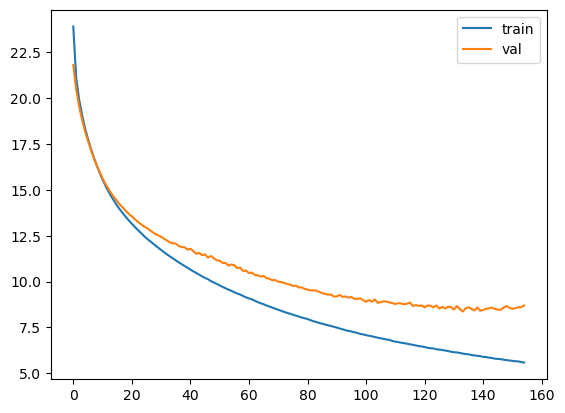

In [53]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()
#plt.axis([0, 300, -30, 5])
plt.savefig("./sequential_files/losses_r1_jaxpriors.png")

In [54]:
# save proposal between rounds
model = fitted_flow

eqx.tree_serialise_leaves("./sequential_files/posterior_r1_jaxpriors.eqx", model)

In [75]:
# save sample parameters for next round
posterior = Transformed(fitted_flow, Invert(preprocess_theta))

samples = posterior.sample(subkey, (100000,), condition=x_o_t)
print(np.shape(samples))
samples = np.reshape(samples, (100000,16))
theta_2 = np.exp(samples)

(100000, 1, 16)


In [76]:
print(np.shape(theta_2))
tr2 = pd.DataFrame(theta_2)
tr2.to_csv("./plotting/tr2_100k.csv", index=False)

(100000, 16)


In [45]:
#theta_3 = pd.read_csv("./previous/thetas_r3.csv")
#theta_3 = theta_3.to_numpy(dtype=np.float32)
theta_2 = pd.read_csv("../simulation/output/round_2/thetas_r2.csv")
theta_2 = theta_2.to_numpy(dtype=np.float32)
theta = pd.read_csv("../simulation/output/round_1/thetas_r1.csv")
theta = theta.to_numpy(dtype=np.float32)
np.shape(theta_2)

(10000, 16)

In [56]:
priors_dict = {
    "captive_time": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "div_time": scipy.stats.lognorm(s=0.7, loc=10000, scale=60000),
    "div_time_dom": scipy.stats.lognorm(s=0.5, loc=500, scale=3000),
    "div_time_scot": scipy.stats.lognorm(s=0.3, loc=0, scale=3000),
    "mig_rate_captive": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_rate_scot": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_length_scot": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "pop_size_captive": scipy.stats.lognorm(s=0.6, loc=0, scale=100),
    "pop_size_domestic_1": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "pop_size_lyb_1": scipy.stats.lognorm(s=1, loc=0, scale=20000),
    "pop_size_lyb_2": scipy.stats.lognorm(s=1.5, loc=5000, scale=100000),
    "pop_size_scot_1": scipy.stats.lognorm(s=1, loc=0, scale=4000),
    "pop_size_eu_1": scipy.stats.lognorm(s=1.3, loc=0, scale=20000),
    "pop_size_eu_2": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "mutation_rate": scipy.stats.lognorm(s=1, loc=0, scale=1e-8),
    "recombination_rate": scipy.stats.lognorm(s=0.5, loc=0.4e-8, scale=9e-9)
}

theta = []
for key, prior in priors_dict.items():
    theta.append(prior.rvs(10000))
theta = np.concatenate(theta, axis=0)
print(np.shape(theta))
theta = np.reshape(theta, (16,10000))
print(np.shape(theta))

(160000,)
(16, 10000)


In [57]:
params = {
    "captive_time": {"bins" : np.arange(0, 100, 1), "lims" : [0, 100]},
    "div_time": {"bins" : np.arange(0, 400000, 3000), "lims" : [0, 400000]},
    "div_time_dom": {"bins" : np.arange(500, 11000, 100), "lims" : [500, 11000]},
    "div_time_scot": {"bins" : np.arange(1000, 7000, 50), "lims" : [1000, 7000]},
    "mig_rate_captive": {"bins" : np.arange(0, 0.4, 0.005), "lims" : [0, 0.4]},
    "mig_rate_scot": {"bins" : np.arange(0, 0.3, 0.004), "lims" : [0, 0.3]},
    "mig_length_scot": {"bins" : np.arange(0, 80, 1), "lims" : [0, 80]},
    "pop_size_captive": {"bins" : np.arange(0, 500, 5), "lims" : [0, 500]},
    "pop_size_domestic_1": {"bins" : np.arange(0, 1000000, 4000), "lims" : [0, 1000000]},
    "pop_size_lyb_1": {"bins" : np.arange(0, 100000, 800), "lims" : [0, 100000]},
    "pop_size_lyb_2": {"bins" : np.arange(0, 750000, 5000), "lims" : [0, 750000]},
    "pop_size_scot_1": {"bins" : np.arange(0, 30000, 200), "lims" : [0, 30000]},
    "pop_size_eu_1": {"bins" : np.arange(0, 150000, 2000), "lims" : [0, 150000]},
    "pop_size_eu_2": {"bins" : np.arange(0, 250000, 2500), "lims" : [0, 250000]},
    "mutation_rate": {"bins" : np.arange(0, 0.6e-7, 0.6e-9), "lims" : [0, 0.6e-7]},
    "recombination_rate": {"bins" : np.arange(0.5e-8, 3.5e-8, 3e-10), "lims" : [0.5e-8, 3.5e-8]}
         }

names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

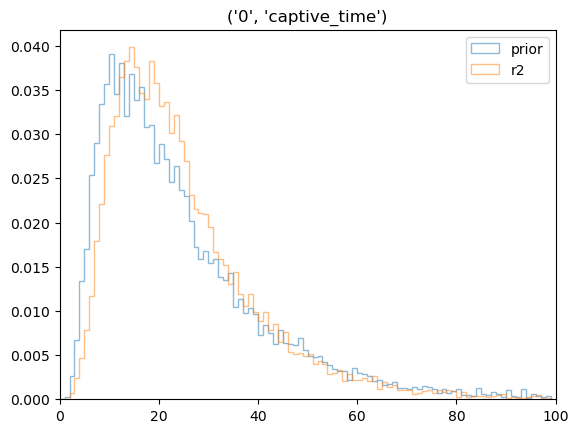

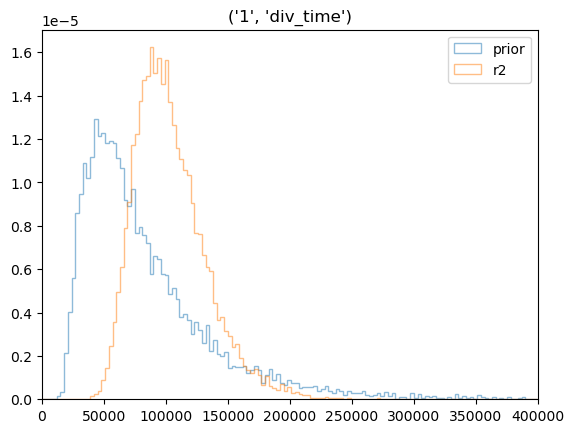

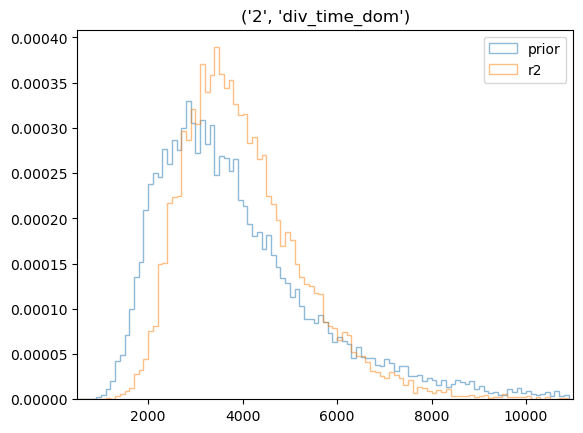

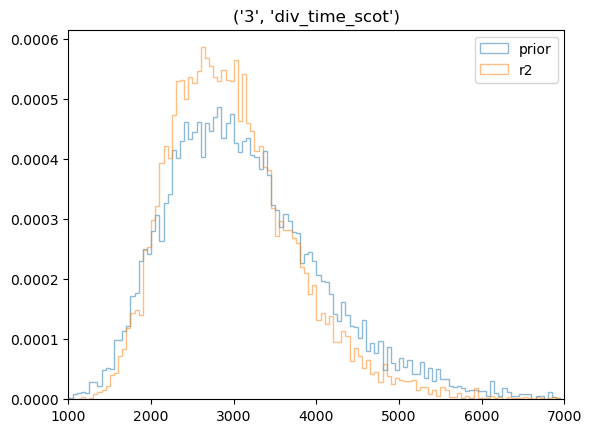

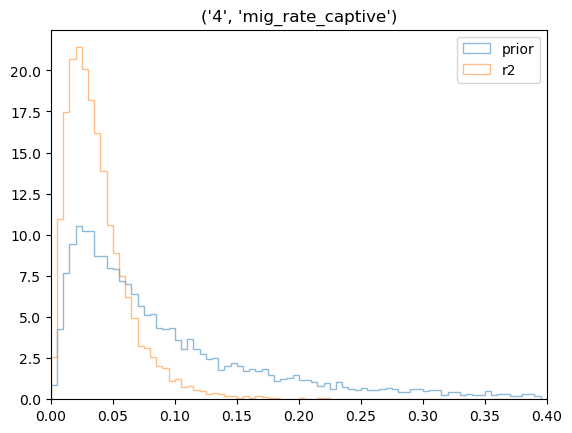

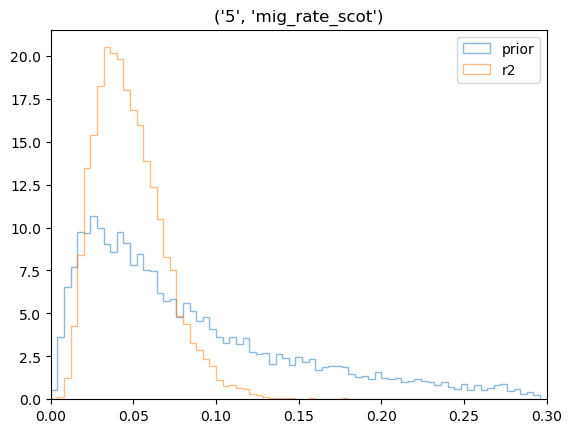

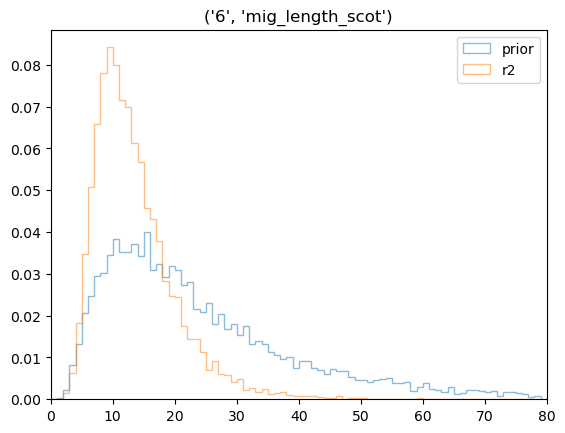

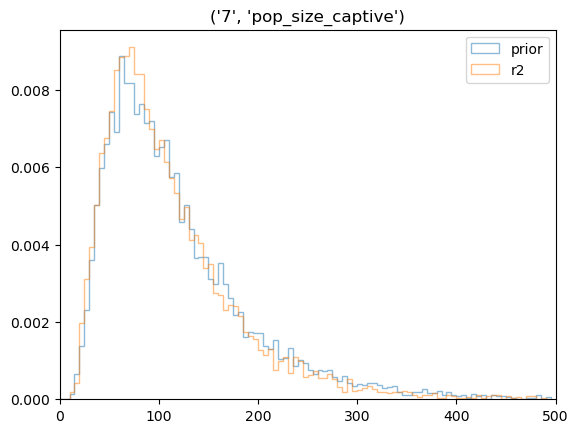

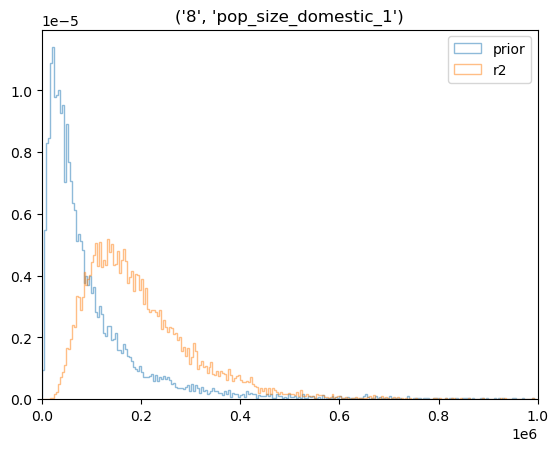

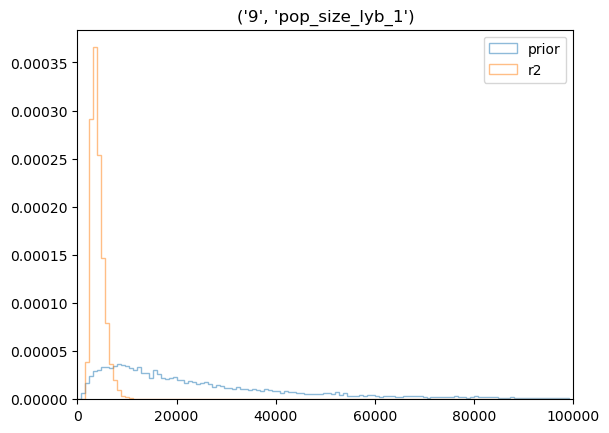

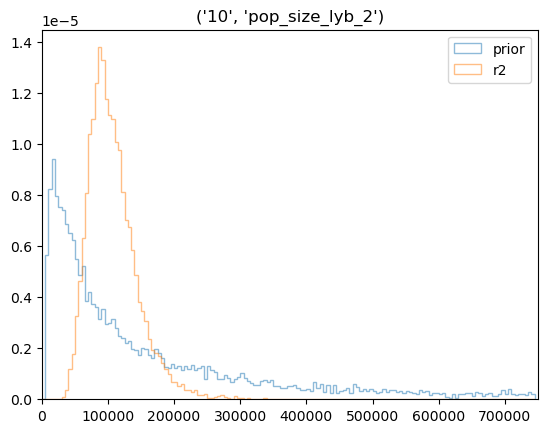

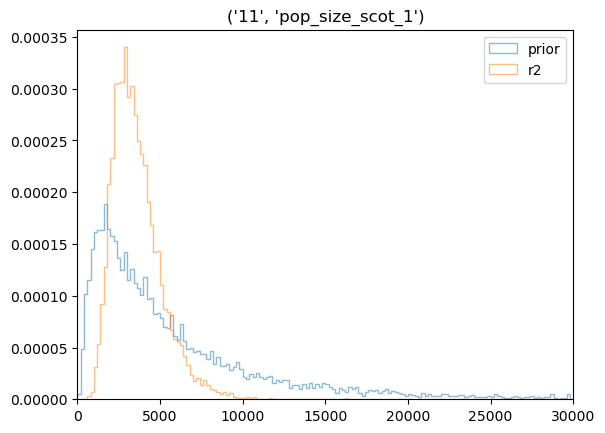

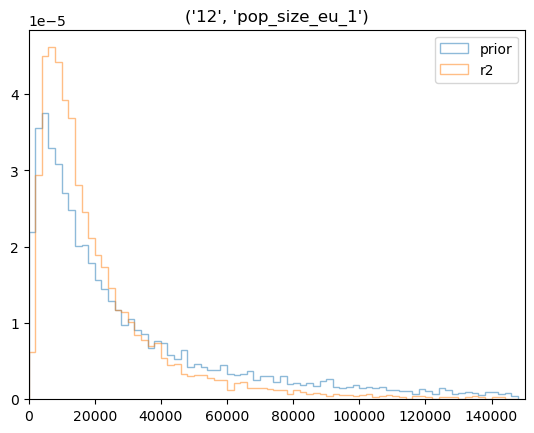

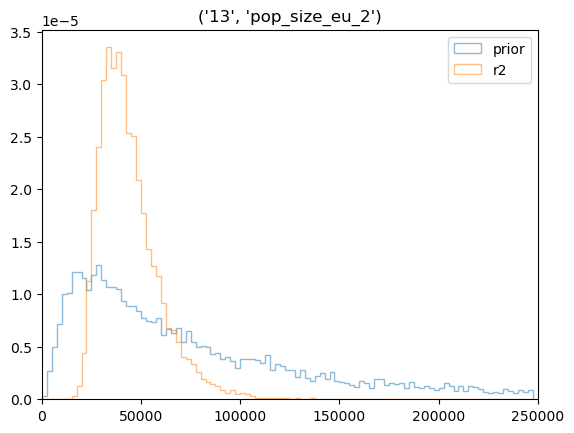

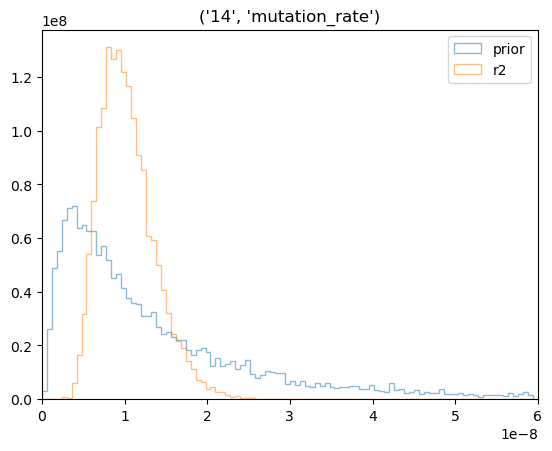

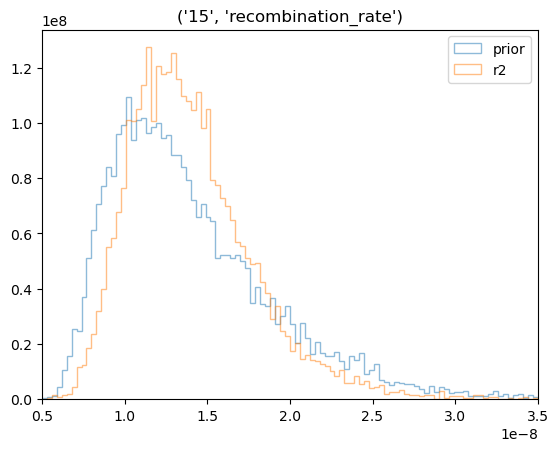

In [58]:
# plot parameter distributions
for num in range(0,16): 
    stat = names[num]
    
    plt.hist(theta[num][:],
             alpha=0.5,
             label='prior', bins=params[stat]["bins"], density=True, histtype='step')
    
    plt.hist(theta_2[:,num],
             alpha=0.5,
             label='r2', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_3[:,num],
             #alpha=0.5,
             #label='r3', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_4[:,num],
         #    alpha=0.5,
         #    label='r4', bins=params[stat]["bins"], density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(label=(str(num), stat))
    #plt.yticks([])
    plt.xlim(params[stat]["lims"])
    plt.show()